###  <center> ETUDE DE CAS : ELECTRICITY DATASET </center>

## Analyse de données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display
sns.set(style="ticks", color_codes=True)

In [2]:
data = pd.read_csv('electricity/training_inputs.csv', sep =';')
label = pd.read_csv('electricity/training_outputs.csv', sep = ';')
data['target'] = label.TARGET.values

In [3]:
print(data.shape)

(85529, 110)


In [4]:
columns = data.columns.tolist()
cols_id = ['COD_INSEE', 'COD_IRIS']
cols_c = [col for col in columns if col[0] == 'C' and col not in cols_id]
cols_s = [col for col in columns if col[0] == 'S' and col not in cols_id] 
cols_q = [col for col in columns if col[0] == 'Q' and col not in cols_id]

### Variables INSEE et IRIS

In [5]:
df = data[cols_id]
display(df.COD_INSEE.value_counts().head())
display(df.COD_IRIS.value_counts().head())

31555.0    751
6088.0     598
33063.0    559
44109.0    458
34172.0    385
Name: COD_INSEE, dtype: int64

693830302.0    57
60883102.0     45
561850106.0    40
351770000.0    39
222250000.0    39
Name: COD_IRIS, dtype: int64

In [6]:
df_dict = dict(zip([i for i in df.columns] , [len(df[i].unique().tolist()) for i in df.columns]))
print("Le nombre de valeurs uniques prises par les variables:")
df_dict

Le nombre de valeurs uniques prises par les variables:


{'COD_INSEE': 17348, 'COD_IRIS': 27382}

#### Valeurs absentes et abbérantes

In [7]:
print('Valeurs absents pour les codes INSEE et IRIS :')
display(data[cols_id].isnull().sum())

Valeurs absents pour les codes INSEE et IRIS :


COD_INSEE    1777
COD_IRIS     1727
dtype: int64

In [8]:
df[df.COD_INSEE.isnull() & df.COD_IRIS.notnull()].count()

COD_INSEE     0
COD_IRIS     50
dtype: int64

- Ainsi il y a 50 clients dont on connait le code iris mais pas le code INSEE. On peut facilement retrouver le code INSEE de ces clients.
- Pour le reste, une approche consisterait à remplacer les valeurs absentes par le code_insee le plus fréquent et l'iris la plus fréquente associée à ce code_insee ou encore les répartir uniformément dans les 10 INSEEs les plus fréquents

In [9]:
data.loc[data.COD_INSEE.isnull() & data.COD_IRIS.notnull(), 'COD_INSEE'] =\
data[data.COD_INSEE.isnull() & data.COD_IRIS.notnull()]['COD_IRIS'].apply(lambda x: float(str(x)[:5]))

#### Correlation avec la variable cible

In [10]:
df = data[cols_id + ['target']].copy()
df_insee = (100*df.groupby('COD_INSEE')['target'].apply(lambda x : np.sum(x)/len(x))).reset_index()

In [11]:
tmp = df_insee.copy()
tmp.sort_values(by = 'target', ascending = False).head(5)

,COD_INSEE,target
5625,32192.0,100.0
6574,36096.0,100.0
16294,85233.0,100.0
6621,36195.0,100.0
6620,36194.0,100.0


Il y a des INSEEs dans lesquels le taux de positif est de 100% mais généralement la taille de ces INSEE est très faible (échantillons de l'ordre d'une dizaine). 

On represente ensuite la distribution de la variable cible selon les départements :

In [12]:
def f(x):
    try :
        return float(str(x)[:2])
    except :
        return x
df['dep'] = df['COD_INSEE'].apply(f)
data['dep'] = data['COD_INSEE'].apply(f)

In [13]:
def get_unique_values(df) :
    df_dict = dict(zip([i for i in df.columns],
                       [len(df.loc[df[col].notnull(), col].unique().tolist()) for col in df.columns]))
    print("Le nombre de valeurs uniques prises par les variables de type C :")
    print(df_dict)
    return df_dict

def plot_cat_distribution(df, ord_cols, n_ = 3, title = False, figsize = (12, 12)) :
    fig, axes = plt.subplots(round(len(ord_cols) / n_), n_, figsize=figsize)
    for i, ax in enumerate(fig.axes):
        if i <= len(ord_cols):
            col = ord_cols[i]
            if col != 'target' : 
                prop_df = (df[col]
               .groupby(df['target'])
               .value_counts(normalize=True)
               .rename('prop')
               .reset_index())
                sns.barplot(x=col, y='prop', hue='target', data=prop_df, ax=ax)
                ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
                if title :
                    ax.set_title(col +' '+ str(tmp[col])[:3]+ '% valeurs nulls')
    fig.tight_layout()
def plot_cont_distribution(df, cont_cols, figsize = (18, 8)) :
    fig, ax = plt.subplots(round(len(cont_cols) / 4), 4, figsize=figsize)
    for i, ax in enumerate(fig.axes):
        if i <= len(cont_cols) - 1:
            col = cont_cols[i]
            sns.stripplot(x="target", y=col, data=df, ax = ax);

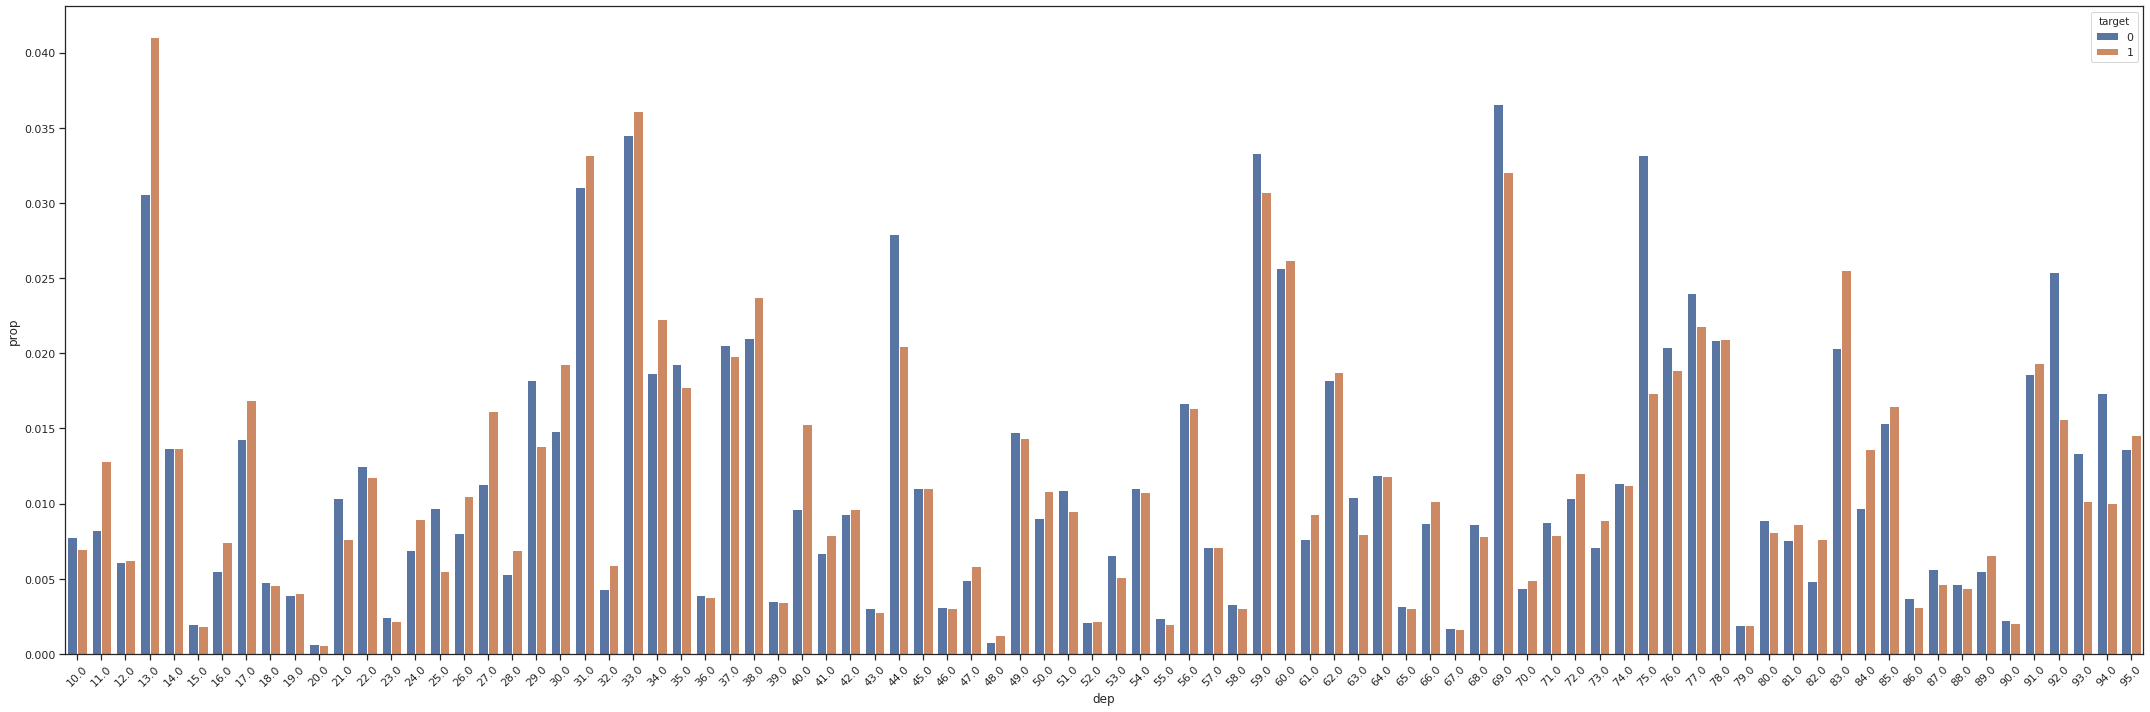

In [14]:
plot_cat_distribution(df, ord_cols = ['dep'], n_ = 1, title = False, figsize = (30, 10))

In [15]:
data['dep'] = data['COD_INSEE'].apply(f)
data['dep'].fillna(69.0, inplace = True)

Les départements 11,13 et 27 sont statistiquement favorables à la variable cible, contrairement aux départements 44, 75, 92 et 94.

### Analyse des variables de type C

In [16]:
df = data[cols_c + ['target']]
display(df.head())
df_dict = get_unique_values(df)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,target
0,EA,RA,C,IB,0,0,0,YA,RA,8,2286,OB,RC,OB,2,214,212,16,7,0
1,EA,RA,C,IA,0,0,0,YB,RA,166,2220,OB,RC,OB,3,511,414,15,19,0
2,EA,RC,B,IA,0,0,0,YB,RA,17,2265,OC,R7,OA,4,407,405,17,8,0
3,EA,RA,C,IB,0,0,0,YB,RA,16,2250,OA,RC,OB,3,712,410,16,12,1
4,EA,RA,B,IB,0,0,0,YA,RA,23,2305,OB,RC,OA,1,206,204,17,4,0


Le nombre de valeurs uniques prises par les variables de type C :
{'C1': 1, 'C2': 4, 'C3': 9, 'C4': 2, 'C5': 2, 'C6': 2, 'C7': 2, 'C8': 2, 'C9': 2, 'C10': 320, 'C11': 317, 'C12': 4, 'C13': 5, 'C14': 2, 'C15': 15, 'C16': 108, 'C17': 65, 'C18': 16, 'C19': 150, 'target': 2}


In [17]:
print('Les variables de type C contenant des valeurs absentes sont :',
      (df.isnull().sum()[(df.isnull().sum() > 0) == True]).index.tolist())

Les variables de type C contenant des valeurs absentes sont : []


- La variable catégorielle C1 ne prend qu'une seule valeur, elle peut donc être retirée de l'analyse
- Compte tenue de la taille des observations : 85529, toutes les variables C peuvent être considérées comme catégorielles. Mais selon que cela fasse sens de les ordonner (age par exemple) elles peuvent être traitées comme continues

In [18]:
cols_to_remove = ['C1']

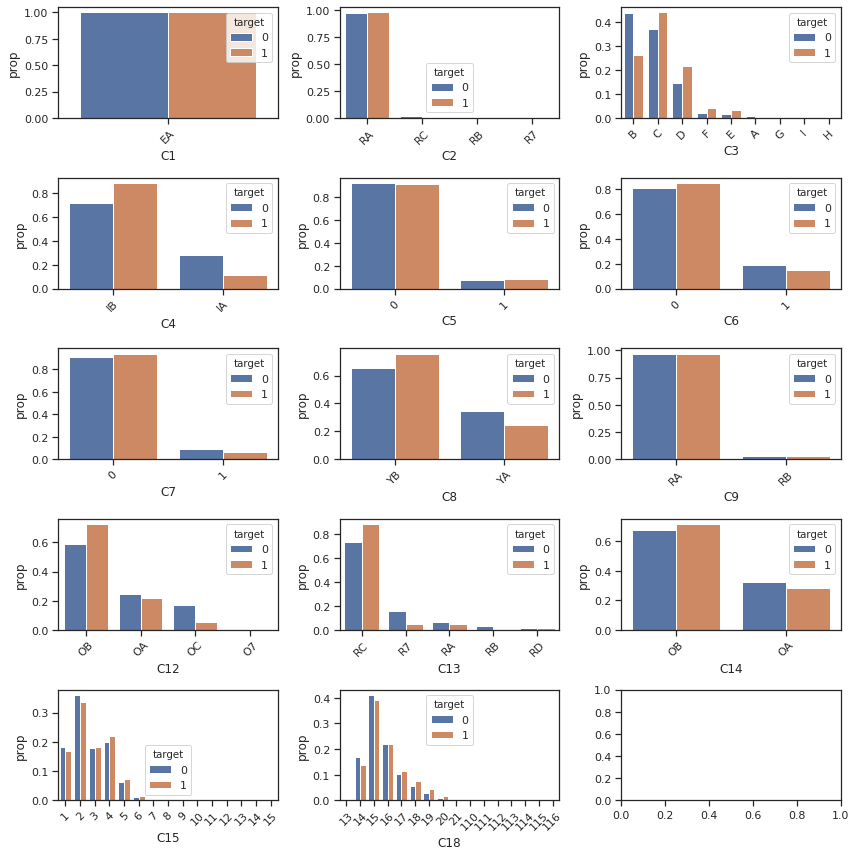

In [19]:
ord_cols = [col for col in df.columns if df_dict[col] < 20]
plot_cat_distribution(df, ord_cols)

A priori, les variables C2, C5 et C9 ne sont pas corrélées à la variable cible. Elles peuvent être retirées si jamais l'on souhaite implementer un modèle de prédiction.

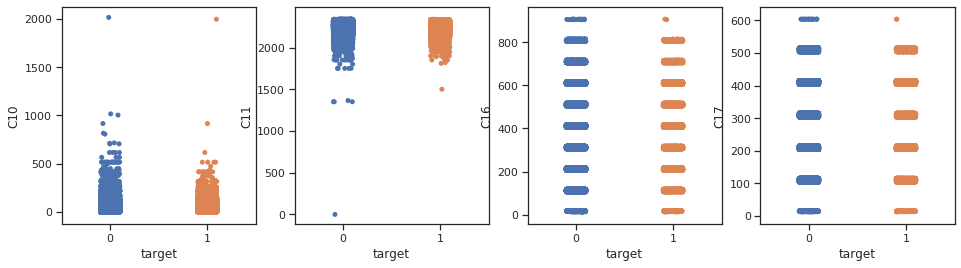

In [20]:
cont_cols = [col for col in df.columns if col not in ord_cols]
plot_cont_distribution(df, cont_cols, figsize = (16, 4))

La sortie semble indépendante des variables C10, C11, C16, C17

### Analyse des variables de type  S

In [21]:
df = data[cols_s + ['target']].copy()
display(df.head())
df_dict = get_unique_values(df)

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,target
0,1.0,0,2013-11-15,2014-02-22,2013-09-08,2013-09-07,2013-09-07,6,8,1,2,1,0
1,3.0,2,2013-11-15,2014-08-07,2013-04-18,2013-09-14,2014-03-21,11,21,4,1,1,0
2,NaN,0,2013-11-15,2013-11-05,2013-11-05,NaN,NaN,1,3,1,1,0,0
3,4.0,1,2013-11-15,2014-05-30,2013-07-03,2014-01-30,2014-05-18,10,13,4,0,5,1
4,NaN,1,2013-11-15,2013-09-22,2013-09-22,NaN,NaN,1,1,1,0,0,0


Le nombre de valeurs uniques prises par les variables de type C :
{'S1': 147, 'S2': 22, 'S3': 147, 'S4': 699, 'S5': 720, 'S6': 678, 'S7': 592, 'S8': 194, 'S9': 313, 'S10': 124, 'S11': 37, 'S12': 44, 'target': 2}


In [22]:
print('Les variables de type S contenant des valeurs absentes sont :',
      (df.isnull().sum()[(df.isnull().sum() > 0) == True]).index.tolist())

Les variables de type S contenant des valeurs absentes sont : ['S1', 'S6', 'S7']


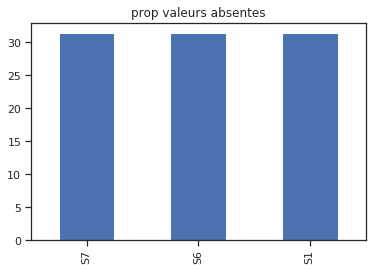

In [23]:
tmp = 100*df.isnull().sum()/len(df)
(tmp[tmp > 0].sort_values(ascending = False)).plot(kind = 'bar')
plt.title(label = 'prop valeurs absentes') ;

#### Traitement des valeurs absentes 
- Les dates seront remplacées par des durées (en jours) avec comme date de référence fixée arbitrairement (2011/11/01)
- Toutes les valeurs absentes seront remplacées par des valeurs médianes

In [24]:
from datetime import datetime
for i in range (3, 8) :
    col = 'S' + str(i)
    df[col] = df[col].astype('datetime64[ns]', copy = False)
    data[col] = data[col].astype('datetime64[ns]', copy = False)
    df[col] = (df[col] - datetime(2011, 11, 1)).dt.days
    data[col] = (data[col] - datetime(2011, 11, 1)).dt.days

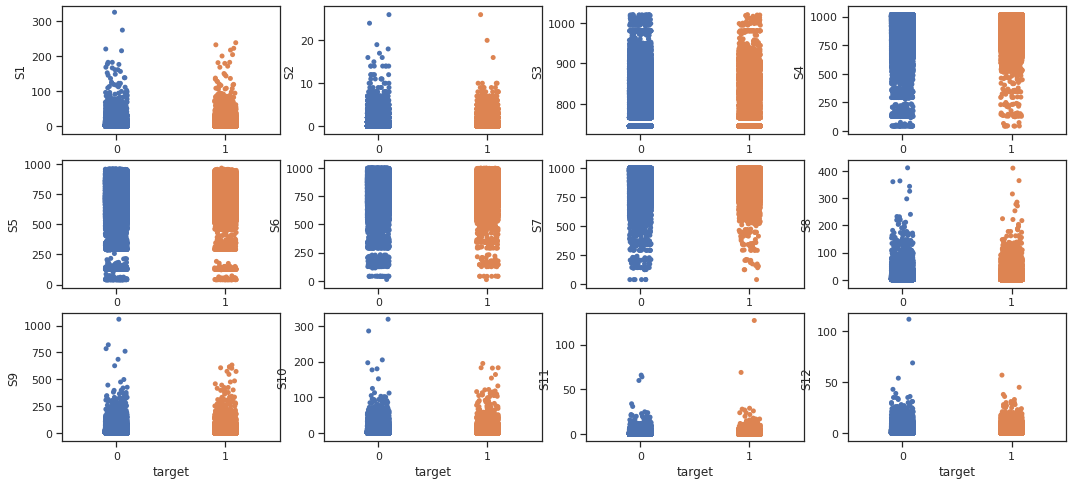

In [25]:
cont_cols = df.columns
plot_cont_distribution(df, cont_cols)

Il n'y a pas de relation immédiate entre la variable cible et les variables de type S.

In [26]:
data['S1'].fillna(data.S1.median(), inplace = True)
data['S6'].fillna(data.S6.median(), inplace = True)
data['S7'].fillna(data.S7.median(), inplace = True)

### Analyse des variables de type Q

Il faut renommer certaines valeurs de variables qui ne sont pas uniformisées ('false', 'False', False etc..)

In [27]:
df = data[cols_q + ['target']].copy()
ord_cols = [col for col in df.columns if len(df.loc[df[col].notnull(), col].unique().tolist()) < 9]
def f_uniform(x) :
    try :
        if (x == False and type(x) == bool) or 'alse' in x :
            return False
        elif (x == True and type(x) == bool) or 'rue' in x :
            return True
        else : 
            return x
    except :
        return x
for col in ord_cols :
    df[col] = df[col].apply(f_uniform)
    data[col] = data[col].apply(f_uniform)
display(df.head())

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q67,Q68,Q69,Q70,Q71,Q72,Q73,Q74,Q75,target
0,HA,ZA,UC,8.0,2286,0.0,False,2.0,25.0,PC,...,False,True,False,True,False,False,NaN,NaN,NaN,0
1,HC,ZA,UC,166.0,2220,NaN,NaN,0.0,23.5,PC,...,False,True,False,True,False,False,True,False,False,0
2,HC,ZA,UA,17.0,2265,NaN,NaN,2.0,25.0,PD,...,False,True,False,True,False,False,NaN,NaN,NaN,0
3,HC,ZA,UC,16.0,2250,NaN,NaN,0.0,25.0,PA,...,False,True,False,True,False,False,NaN,NaN,NaN,1
4,HA,ZA,UA,23.0,2305,4.0,False,2.0,22.0,PC,...,False,False,True,True,False,False,NaN,NaN,NaN,0


In [28]:
df_dict = get_unique_values(df)

Le nombre de valeurs uniques prises par les variables de type C :
{'Q1': 4, 'Q2': 4, 'Q3': 4, 'Q4': 318, 'Q5': 312, 'Q6': 6, 'Q7': 2, 'Q8': 6, 'Q9': 142, 'Q10': 6, 'Q11': 29, 'Q12': 30, 'Q13': 324, 'Q14': 125, 'Q15': 61, 'Q16': 2, 'Q17': 8, 'Q18': 13, 'Q19': 15, 'Q20': 53, 'Q21': 3, 'Q22': 49, 'Q23': 3, 'Q24': 3, 'Q25': 3, 'Q26': 6, 'Q27': 3, 'Q28': 10, 'Q29': 6, 'Q30': 27, 'Q31': 27, 'Q32': 6, 'Q33': 12, 'Q34': 10, 'Q35': 11, 'Q36': 6, 'Q37': 27, 'Q38': 211, 'Q39': 4, 'Q40': 19, 'Q41': 4, 'Q42': 4, 'Q43': 4, 'Q44': 5, 'Q45': 5, 'Q46': 4, 'Q47': 4, 'Q48': 11, 'Q49': 4, 'Q50': 4, 'Q51': 12, 'Q52': 2, 'Q53': 2, 'Q54': 2, 'Q55': 2, 'Q56': 2, 'Q57': 2, 'Q58': 2, 'Q59': 2, 'Q60': 2, 'Q61': 2, 'Q62': 2, 'Q63': 2, 'Q64': 2, 'Q65': 2, 'Q66': 2, 'Q67': 2, 'Q68': 2, 'Q69': 2, 'Q70': 2, 'Q71': 2, 'Q72': 2, 'Q73': 2, 'Q74': 2, 'Q75': 2, 'target': 2}


In [29]:
print('Les variables de type S contenant des valeurs absentes sont :',
      (df.isnull().sum()[(df.isnull().sum() > 0) == True]).index.tolist())

Les variables de type S contenant des valeurs absentes sont : ['Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70', 'Q71', 'Q72', 'Q73', 'Q74', 'Q75']


Analyse des variables avec plus de 20% de valeurs absentes

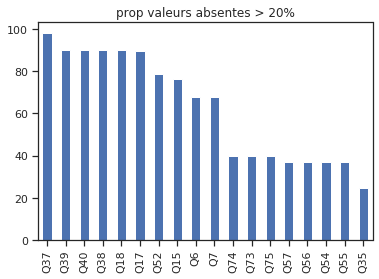

In [30]:
tmp = 100*df.isnull().sum()/len(df)
(tmp[tmp > 20].sort_values(ascending = False)).plot(kind = 'bar')
plt.title(label = 'prop valeurs absentes > 20%');

Première idée : supprimer les variables avec plus de 20% de valeurs absentes mais avant cela faut regarder la distribution de la cible pour les valeurs non absentes de ces variables.

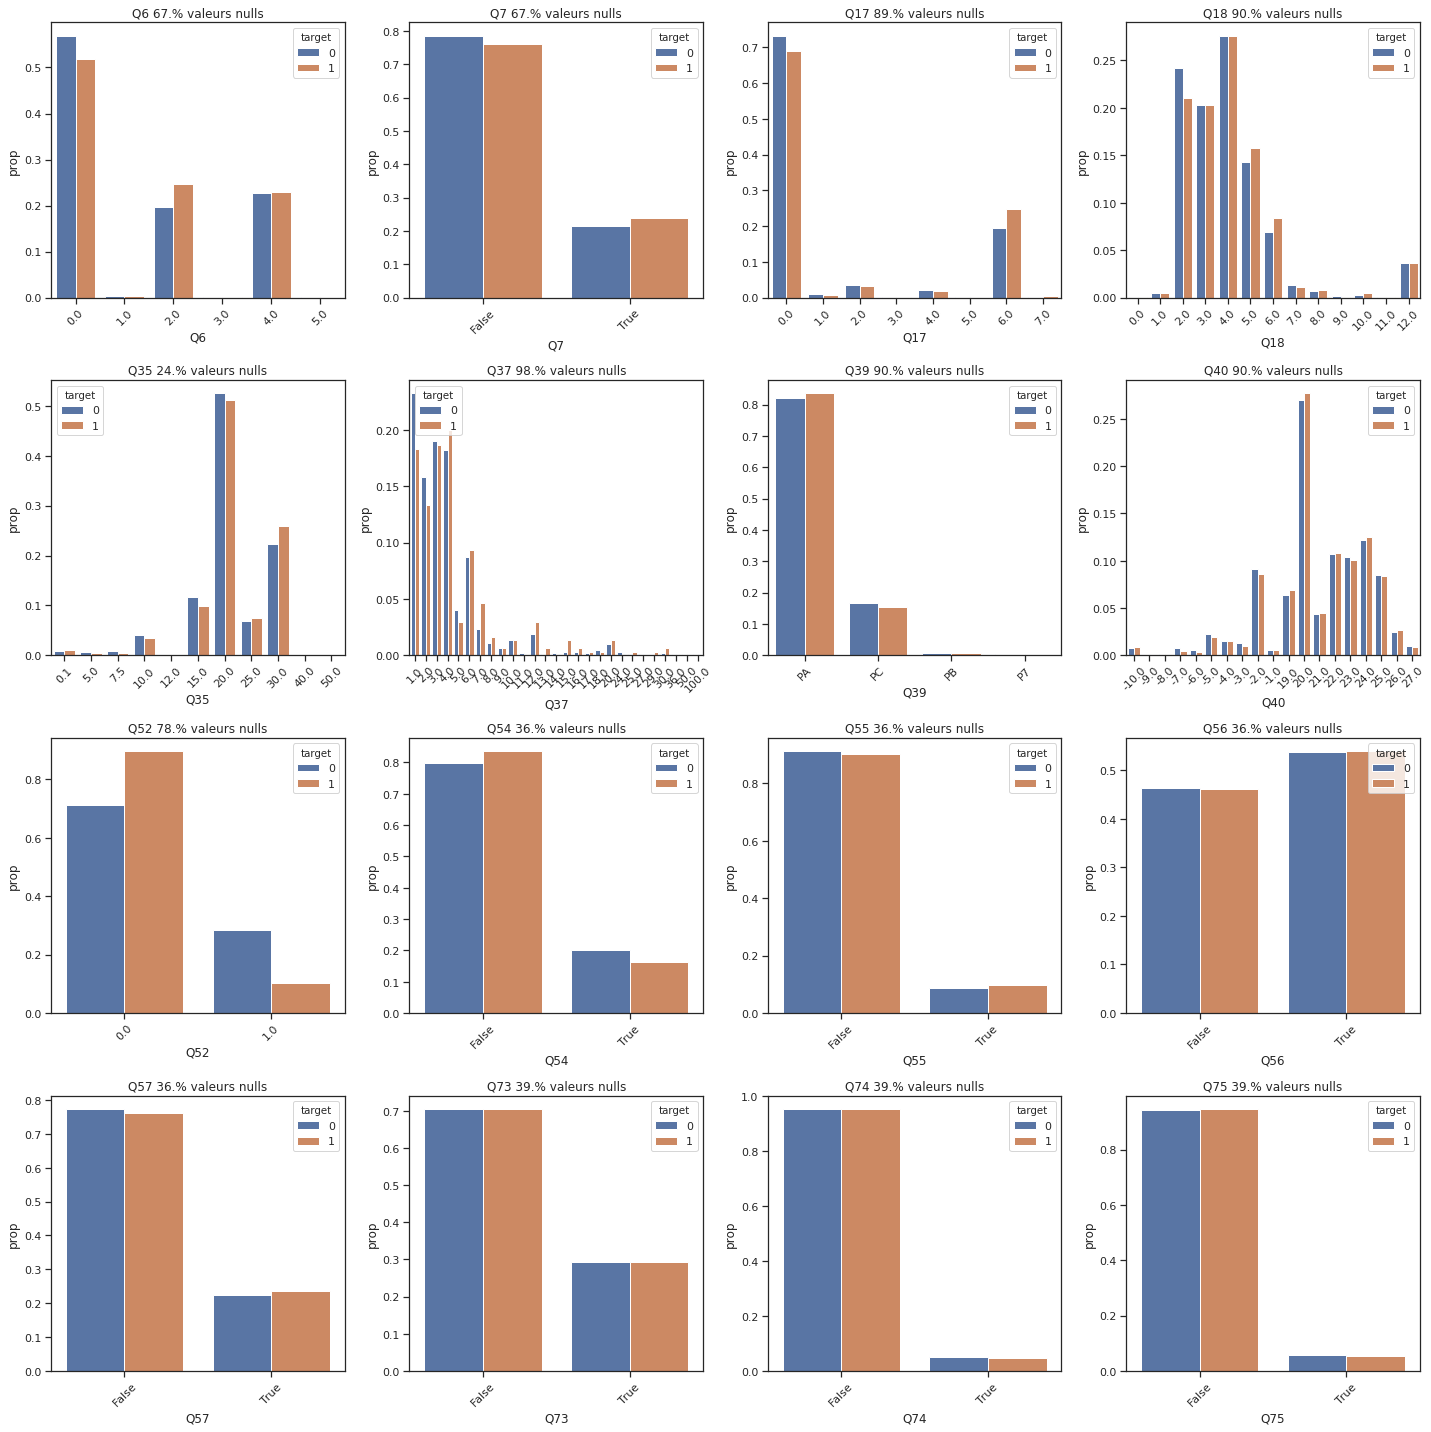

In [31]:
cols_nulls =  [col for col in tmp[tmp > 20].index.tolist() if df_dict[col] < 30]
n_ = 4
plot_cat_distribution(df, cols_nulls, n_, title = True, figsize=(20, 20))

Les variables ci-dessous ont plus de 30% de valeurs absentes et la cible est uniformement répartie sur les valeurs prises par ces variables.

Par conséquent ces variables ne sont pas pertinentes vis-à-vis de l'analyse :  Q6, Q7, Q17, Q18, Q37, Q39, Q40, Q55, Q52, Q54, Q55, Q56, Q57, Q73, Q74, Q75
On observe la même chose pour les variables continues avec plus de 20% de valeurs absentes.

In [32]:
cols_q_remov = ['Q6', 'Q7', 'Q17', 'Q18', 'Q37', 'Q39', 'Q40', 'Q52', 
                  'Q54','Q55', 'Q56', 'Q57', 'Q73', 'Q74', 'Q75'] + ['Q15', 'Q37', 'Q38']
cols_to_remove.extend(cols_q_remov)

In [33]:
df.drop(columns=cols_q_remov, inplace=True)
df_dict = dict(zip([i for i in df.columns],
                   [len(df.loc[df[i].notnull(), i].unique().tolist()) for i in df.columns]))

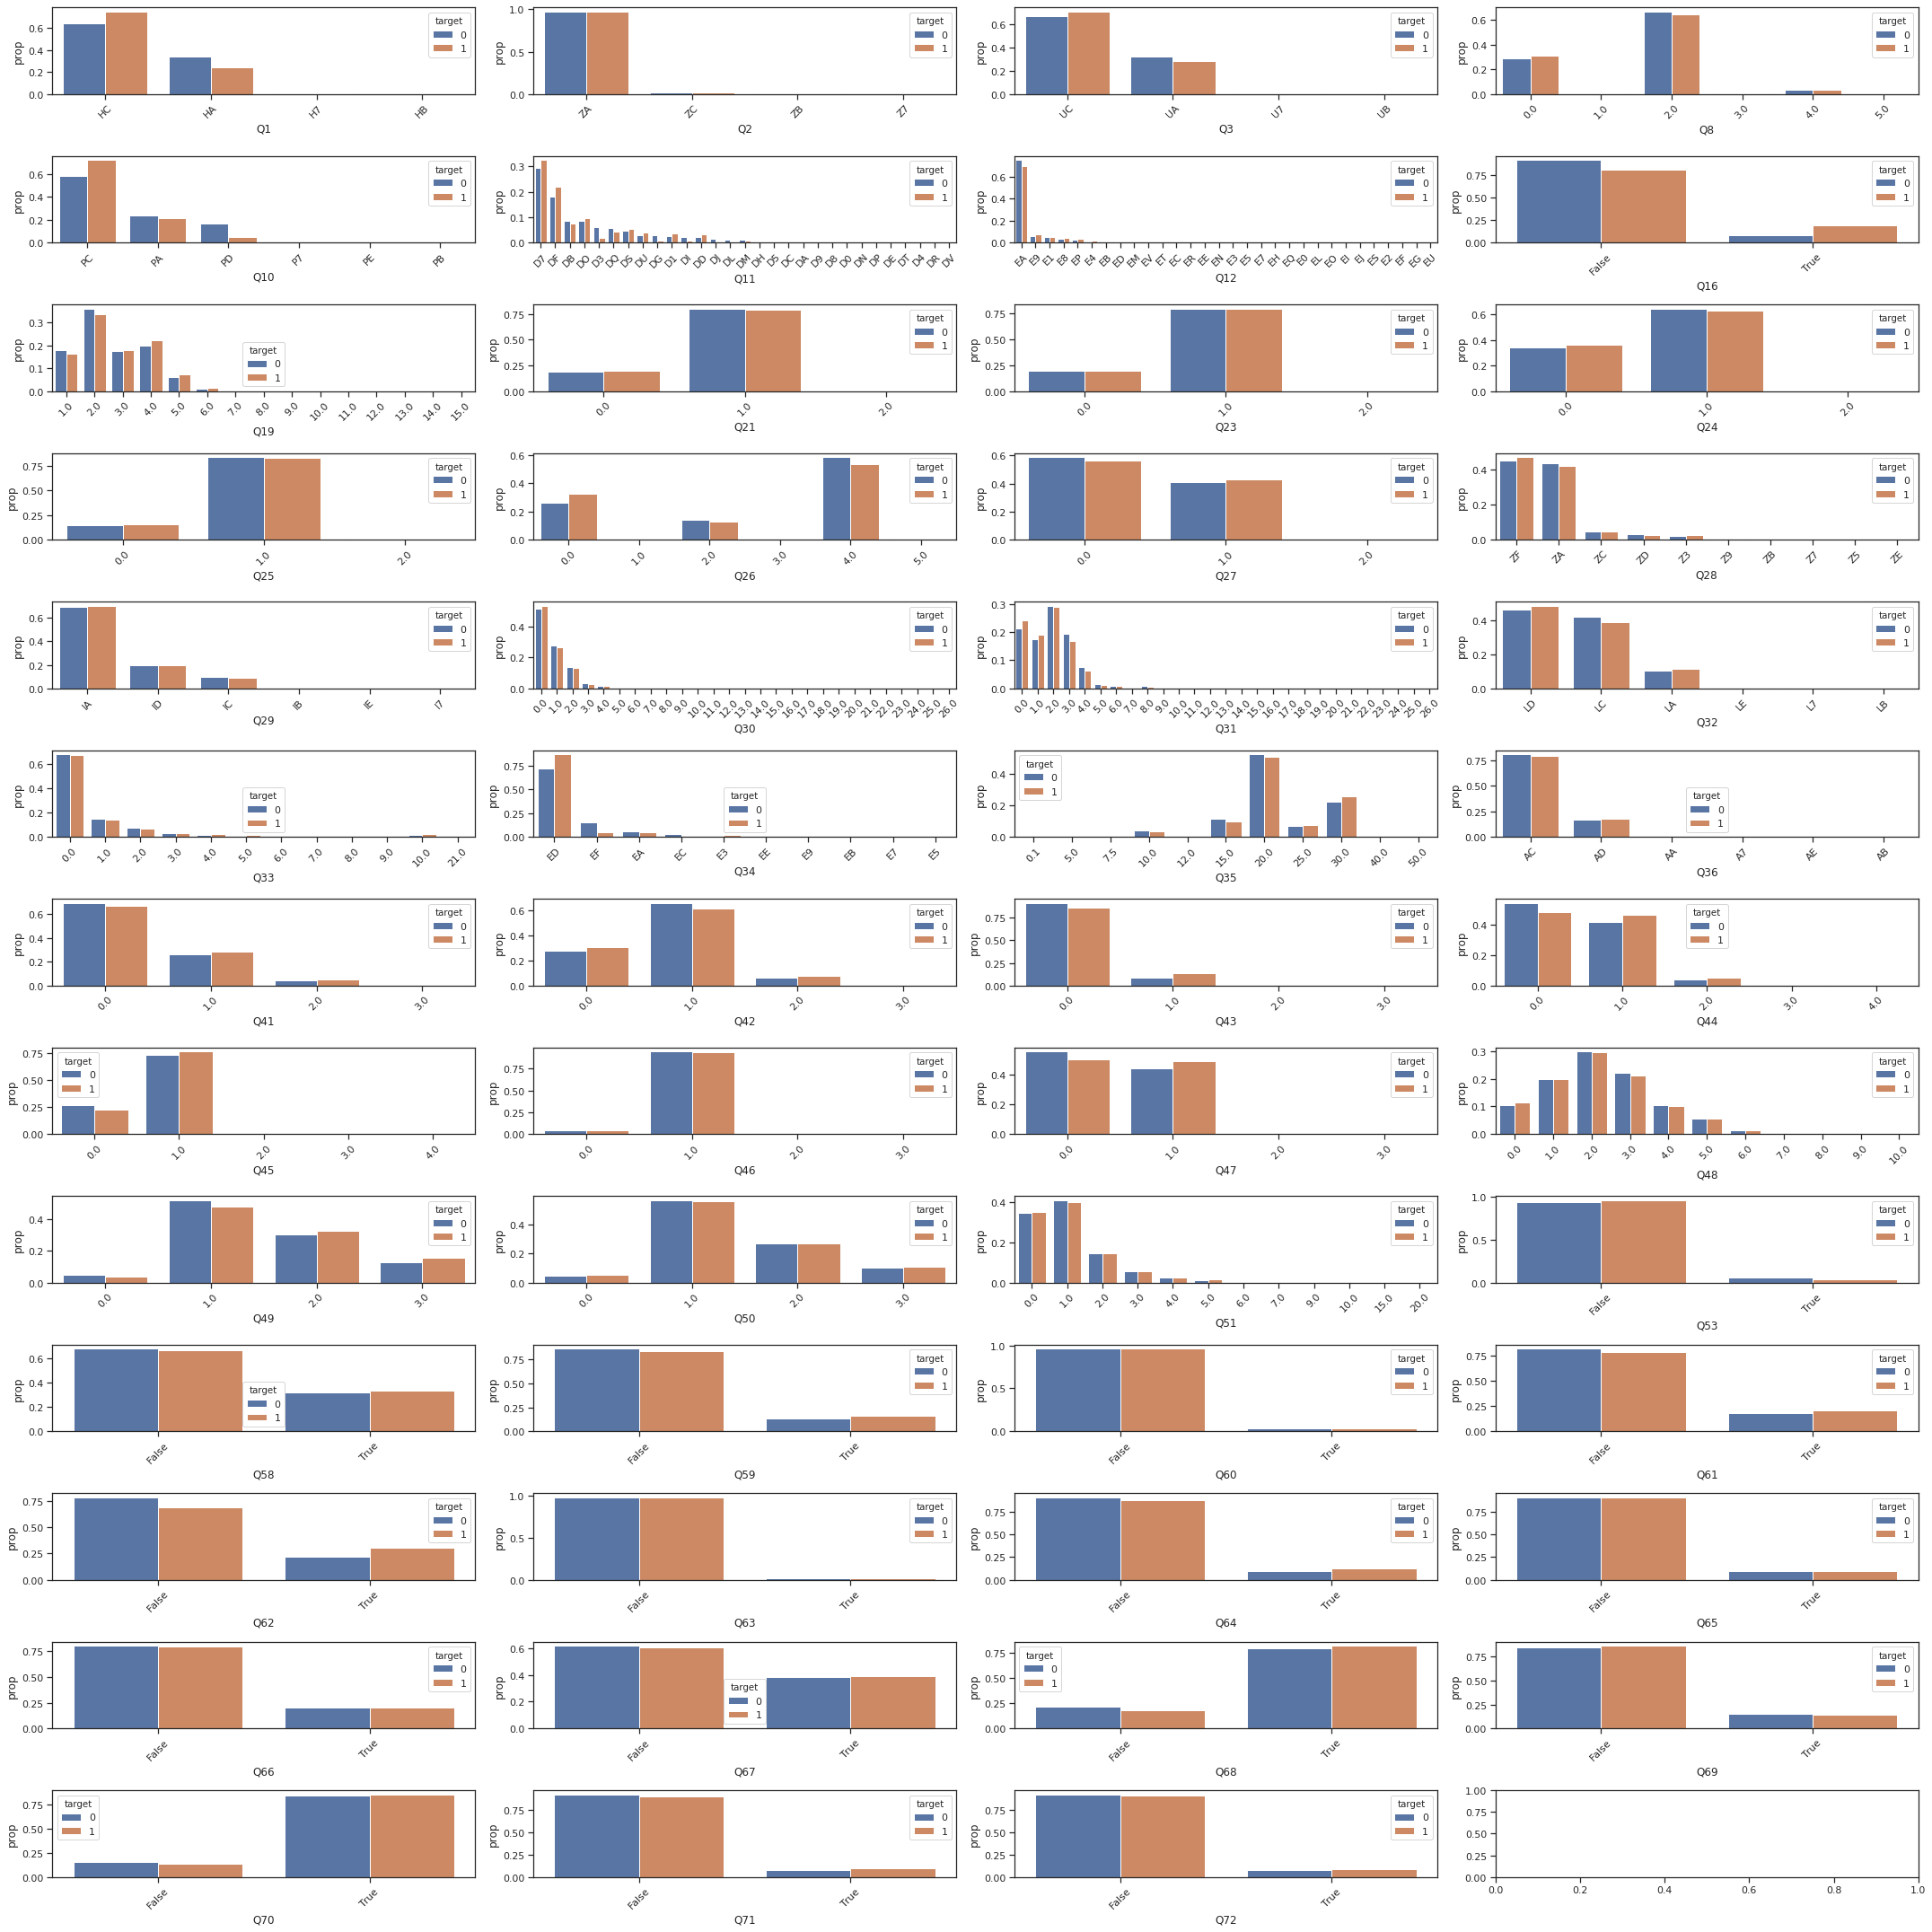

In [34]:
ord_cols = [col for col in df.columns if df_dict[col] < 32]
plot_cat_distribution(df, ord_cols, n_=4, figsize = (30, 30))

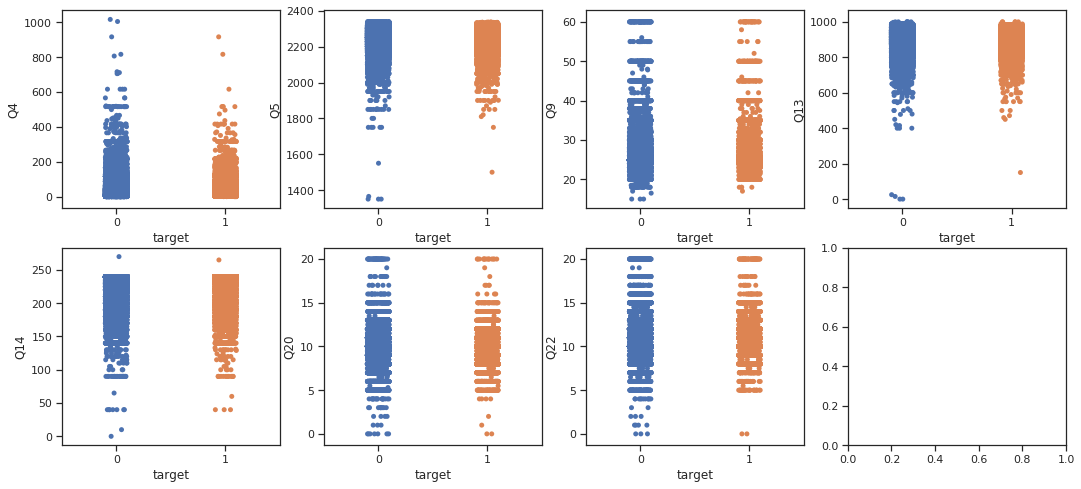

In [35]:
cont_cols_q = [col for col in df.columns if col not in ord_cols]
plot_cont_distribution(df, cont_cols_q)

- Il n'y a pas de commentaires particuliers à faire si ce n'est que la sortie semble fortement indépendante de plusieurs variables de type Q.

- Notons que les valeurs absentes ici peuvent être remplacées par la médiane dans le cas d'une variable continue et la valeur la plus fréquente dans le cas des variables catégorielles
- Si on avait des informations plus précis sur les variables, le traitement des valeurs absentes aurait pu être fait par des médianes par INSEE ou par type de clients par exemple.

## Algorithme pour sélection des variables et prédiction

Pour les modèle ML, on se restreint aux variables les plus pertinentes au vue de l'analyse précédente

In [36]:
cols_c_use = ['C3', 'C4', 'C8', 'C12', 'C13', 'C14']
cols_q_use = ['Q1', 'Q3', 'Q10', 'Q11', 'Q32', 'Q34', 'Q4', 'Q5', 'Q9', 'Q13', 'Q14', 'Q20', 'Q22']
cols_to_use = ['dep']+ cols_s + cols_c_use + cols_q_use
len(cols_to_use)

32

In [37]:
ord_cols = list(data[cols_to_use].select_dtypes(include = ['O']).columns) + ['dep']
for col in cols_q_use :
    if col in ord_cols :
        val = data[col].value_counts().iloc[0]
        data[col].fillna(val, inplace = True)
    else :
        data[col].fillna(data[col].median(), inplace =True)

In [38]:
df_train  = pd.get_dummies(data[cols_to_use], columns=ord_cols)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_train, label.TARGET,
                                                    test_size=0.33, random_state=42, stratify = label.TARGET)

- L'entraînement des modèles dans chacun des cas se fera par cross_validation avec recherche d'hyperparamètres optimaux
- Compte tenu du désequilibre des classes, une mesure de performance pertinente est l'aire sous la courbe précision recall

### Lasso comme Baseline

In [65]:
from sklearn import linear_model
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.transform(X_test)
logistic = linear_model.LogisticRegression()
penalty = ['l1']
C = np.logspace(-1, 2, 5)
params = dict(C=C, penalty=penalty, solver=['liblinear'], max_iter=[100])

clf = GridSearchCV(logistic, params, cv=3, verbose=10, n_jobs = 4)
best_model = clf.fit(X_train_tr, y_train)
y_pred = best_model.predict_proba(X_test_tr)[:,1]

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   33.0s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:  3.2min remaining:  1.6min
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:  3.8min remaining:   57.2s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  4.8min finished


auc precision_recall 0.3163190334386514


Text(0, 0.5, 'Precision')

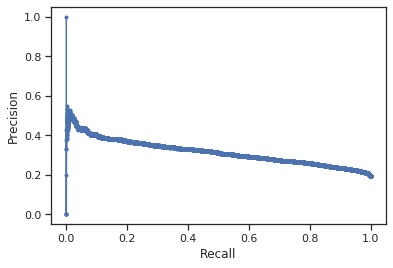

In [66]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
print('auc precision_recall', auc(lr_recall, lr_precision))
plt.plot(lr_recall, lr_precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [70]:
feature_importance = pd.DataFrame(best_model.best_estimator_.coef_.T)
feature_importance = pd.concat([pd.DataFrame(
    X_train.columns.values), feature_importance], axis=1, ignore_index=True)
feature_importance.columns = ['Variable', 'Importance']
feature_importance['Importance_abs'] = feature_importance.Importance.apply(np.abs)
feature_importance = feature_importance.sort_values(
    by='Importance_abs', axis=0, ascending=False).drop(columns = 'Importance_abs')

In [71]:
feature_importance.head(10)

,Variable,Importance
39,C13_RC,0.215810
38,C13_RB,-0.213775
56,Q10_PC,0.151732
28,C4_IA,-0.143375
104,Q34_ED,-0.130904
20,C3_B,-0.125440
13,Q5,-0.112575
8,S9,0.089723
95,Q32_LE,0.081719
12,Q4,0.078661


In [72]:
feature_importance.tail(10)

,Variable,Importance
52,Q10_52184,0.0
53,Q10_P7,0.0
57,Q10_PD,0.0
58,Q10_PE,0.0
100,Q34_E9,0.0
94,Q32_LD,0.0
61,Q11_D1,0.0
64,Q11_D5,0.0
70,Q11_DC,0.0
51,Q3_UC,0.0


### RandomForest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
clf_rf = RandomForestClassifier(class_weight = 'balanced')
params = {'max_depth' : np.arange(15, 50, 5),
          'min_samples_split' : np.arange(2,8,2) , 
          'min_samples_leaf' : np.arange(2,8,2) , 
          'criterion' : ['gini', 'entropy'],
          'n_estimators':[100, 150, 200]}

In [40]:
print(X_train.shape)

(57304, 193)


In [41]:
from sklearn.model_selection import RandomizedSearchCV
OPT = RandomizedSearchCV(clf_rf, param_distributions = params,
                      cv = 3, n_iter = 60, scoring='f1', n_jobs=-1, verbose = 10)
OPT.fit(X_train, y_train);

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   55.5s
/home/jores/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.6min
[Parallel(n_jobs=

auc precision_recall 0.34999330328277084


Text(0, 0.5, 'Precision')

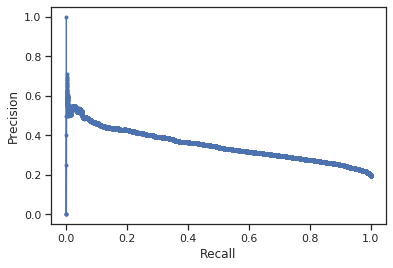

In [47]:
best_model = OPT.best_estimator_
y_pred = best_model.predict_proba(X_test)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
print('auc precision_recall', auc(lr_recall, lr_precision))
plt.plot(lr_recall, lr_precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision');

Remarque : le RandomForest est meilleur par rapport au Lasso

In [48]:
feature_importance = pd.DataFrame(best_model.feature_importances_)
feature_importance = 100.0 * \
    (feature_importance / feature_importance.max())
feature_importance = pd.concat([pd.DataFrame(
    X_train.columns.values), feature_importance], axis=1, ignore_index=True)
feature_importance.columns = ['Variable', 'Importance']
feature_importance = feature_importance.sort_values(
    by='Importance', axis=0, ascending=False)

In [49]:
feature_importance.head(10)

,Variable,Importance
4,S5,100.000000
5,S6,80.293863
13,Q5,72.199010
12,Q4,68.775754
15,Q13,62.601863
7,S8,61.846339
8,S9,61.283692
3,S4,52.804328
29,C4_IB,48.238093
2,S3,48.080569
